# **Identifying the drivers of positive job outcomes**

Develop a weighted lexicon that enables us to identify and measure the impact of hard skills and soft skills on job outcomes.

Instead of relying on generic text analysis that may surface irrelevant themes, we will build a dictionary that assigns importance scores to specific competencies we know matter for employment success.

This approach will allow us to  assess which skills, technical capabilities like certifications and software expertise versus interpersonal abilities like communication and leadership are most predictive of positive job outcomes.

## Methodology Overview

1.  **Lexicon Development:** Predefined lists of `General_HardSkills` and `General_SoftSkills` were meticulously curated to focus the analysis on specific, relevant competencies for the data field.
2.  **Data Extraction & Preparation:**
    *   CSV files, sourced from Google Drive, were loaded into individual pandas DataFrames.
    *   DataFrames were systematically renamed (e.g., `datascience_comments`, `dataengineering_posts`) for improved clarity and manageability.
    *   Comments and posts for each subreddit underwent a detailed processing pipeline: relevant columns were selected, text content was consolidated under a unified `text_content` column, a `type` column (indicating 'comment' or 'post') was added, and missing numerical values for scores and comment counts were imputed with zeros.
    *   Subreddit-specific master DataFrames were subsequently constructed by concatenating their respective processed comments and posts.
3.  **Global Master DataFrame Creation:** All individual subreddit master DataFrames were merged into a singular `global_master_df`. A `category` column was introduced to facilitate easy identification of the originating subreddit for each entry.
4.  **Text Preprocessing:** A dedicated `preprocess_text` function was applied to the `text_content` column, transforming all text to lowercase and removing punctuation. The results were stored in a new `processed_text_content` column.
5.  **Skill Identification (Refined Lexicon Matching):**
    *   A robust `extract_refined_skills` function, leveraging NLTK's Part-of-Speech (POS) tagging and regular expressions, was developed and applied.
    *   This function employs a two-phase approach: first, it uses `RegexpParser` to identify multi-word skill phrases (e.g., 'machine learning', 'data visualization'). Second, it explicitly checks for all lexicon terms (both single and multi-word) within the text, employing regex for precise whole-word matching and POS tag validation (ensuring terms are used as Nouns or Verbs) for single words to ensure contextual relevance.
    *   This process populated `identified_hard_skills` and `identified_soft_skills` columns in the `global_master_df`.
6.  **Weighted Skill Scoring:**
    *   Initial weights (e.g., 1 for each skill) were assigned to `hard_skills_weights` and `soft_skills_weights`.
    *   `hard_skill_score`, `soft_skill_score`, and a `total_skill_score` were calculated for each entry based on the presence and weights of identified skills.
7.  **Engagement Metric Calculation:**
    *   Post-level metrics, such as `post_upvotes` and `total_comments_on_post`, were integrated into the `global_master_df`.
    *   An `engagement_metric` was computed for each post/comment, combining comment scores, post scores, and total comments to quantify overall interaction.
    *   An `overall_weighted_skill_engagementscore` was derived by multiplying the `total_skill_score` by the `engagement_metric`, reflecting the impact of skilled content on engagement.
8.  **Sentiment Analysis:**
    *   NLTK's VADER sentiment analyzer was utilized to calculate a `sentiment_polarity` (compound score) for each `processed_text_content` entry, capturing the emotional tone.
    *   A `positive_sentimentscore` was calculated by multiplying the `engagement_metric` by `sentiment_polarity`, emphasizing positively received content.
9.  **Job Outcome Driver Score:**
    *   A list of `outcome_anchors` (e.g., 'hired', 'promotion', 'interview') was defined to pinpoint discussions related to career progression.
    *   An `outcome_driver_score` was computed, which significantly boosts scores for entries exhibiting positive sentiment alongside the mention of these anchor words, thereby highlighting content strongly indicative of positive job outcomes.
10. **Final Skill Analysis DataFrame (`final_skillsanalysis_df`):**
    *   Identified skills were unpivoted to a long format, linking each skill mention to its `outcome_driver_score`, `positive_sentimentscore`, `overall_weighted_skill_engagementscore`, and original `category` (subreddit).
    *   Key metrics were aggregated by skill (e.g., mean scores).
    *   A normalized subreddit dominance matrix (`_share_pct`) was generated to illustrate the proportional presence of each skill within different subreddits, relative to total skill mentions in those communities.
    *   This matrix was subsequently merged with the aggregated skill metrics, and the final DataFrame was sorted by `outcome_driver_score`.
11. **Visualization:**
    *   Bar charts were created to visually represent the Top 15 Hard and Soft Skills driving positive job outcomes.
    *   A bar chart was generated to illustrate the Top 15 Skills by Community Sentiment.
    *   Heatmaps were employed to display the normalized subreddit dominance for the Top 15 Hard and Soft Skills, effectively showcasing where each skill is most predominantly discussed across various communities.



###List of Lexicons

General_HardSkills = [
    "sql", "python", "r", "excel", "tableau", "power bi", "vlookup", "pivot tables","cloud", "aws", "documentation",
    "azure", "gcp", "spark", "pandas", "numpy", "statistics", "machine learning", "data visualization", "dashboard", "deep learning", "nlp", "scikit-learn", "tensorflow", "pytorch", "model deployment", "mlops",
    "data modeling", "pipeline", "database", "etl", "git", "data warehouse", "databricks", "data architecture"
]

General_SoftSkills = [
    "communication", "storytelling", "business acumen", "stakeholder management", "business insights", "storytelling",
    "presentation", "collaboration", "problem solving", "critical thinking", "analytical", "attention to detail",
    "curiosity", "adaptability", "cross functional", "agile"
]



# Data Extraction

**Creating dataframes from the extracted files**

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
print("The 'os' module has been imported.")

The 'os' module has been imported.


In [ ]:
drive_data_path = '/content/drive/MyDrive/04_Career/McGill/INSY669 - Text Analytics/Project/Data'
all_drive_files_and_dirs = os.listdir(drive_data_path)
drive_data_files_paths = []

for file_name in all_drive_files_and_dirs:
    if file_name.endswith('.csv'):
        full_path = os.path.join(drive_data_path, file_name)
        drive_data_files_paths.append(full_path)

print(f"Identified {len(drive_data_files_paths)} CSV files in Google Drive: {drive_data_files_paths}")

Identified 10 CSV files in Google Drive: ['/content/drive/MyDrive/04_Career/McGill/INSY669 - Text Analytics/Project/Data/reddit_analytics_top_10_comments_20260205_202337.csv', '/content/drive/MyDrive/04_Career/McGill/INSY669 - Text Analytics/Project/Data/reddit_datascience_top_10_comments_20260205_185746.csv', '/content/drive/MyDrive/04_Career/McGill/INSY669 - Text Analytics/Project/Data/reddit_datascience_1000_posts_20260205_185746.csv', '/content/drive/MyDrive/04_Career/McGill/INSY669 - Text Analytics/Project/Data/reddit_dataengineering_top_10_comments_20260205_195242.csv', '/content/drive/MyDrive/04_Career/McGill/INSY669 - Text Analytics/Project/Data/reddit_dataanalysis_top_10_comments_20260205_185423.csv', '/content/drive/MyDrive/04_Career/McGill/INSY669 - Text Analytics/Project/Data/reddit_dataanalysis_1000_posts_20260205_185423.csv', '/content/drive/MyDrive/04_Career/McGill/INSY669 - Text Analytics/Project/Data/reddit_analytics_1000_posts_20260205_202337.csv', '/content/drive/MyD

In [ ]:
dataframes = {}

for file_path in drive_data_files_paths:
    # Extract filename without extension for DataFrame name
    file_name_with_ext = os.path.basename(file_path)
    df_name = os.path.splitext(file_name_with_ext)[0]

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Store the DataFrame in the dictionary
    dataframes[df_name] = df

print(f"Loaded {len(dataframes)} DataFrames. Keys: {dataframes.keys()}")

Loaded 10 DataFrames. Keys: dict_keys(['reddit_analytics_top_10_comments_20260205_202337', 'reddit_datascience_top_10_comments_20260205_185746', 'reddit_datascience_1000_posts_20260205_185746', 'reddit_dataengineering_top_10_comments_20260205_195242', 'reddit_dataanalysis_top_10_comments_20260205_185423', 'reddit_dataanalysis_1000_posts_20260205_185423', 'reddit_analytics_1000_posts_20260205_202337', 'reddit_dataanalytics_1000_posts_20260205_182058', 'reddit_dataengineering_1000_posts_20260205_195242', 'reddit_dataanalytics_top_10_comments_20260205_182058'])


In [ ]:
renamed_dataframes = {}

for original_name, df in dataframes.items():
    new_name = original_name

    if 'comments' in original_name:
        # Example: 'reddit_analytics_top_10_comments_...' -> 'analytics_comments'
        parts = original_name.split('_')
        # Find the index of 'comments' to get the category before it
        comments_idx = parts.index('comments')
        if comments_idx > 0:
            # The category should be the part before 'top_10' or '1000'
            # For 'top_10_comments', it's parts[1]
            # For 'dataanalytics_top_10_comments', it's 'dataanalytics'
            # A safer way: find the part between 'reddit_' and the part before 'comments'
            # Let's assume the part after 'reddit_' and before 'top_10' or '1000' is the category
            if 'top' in parts and '10' in parts and parts.index('top') == comments_idx - 2:
                category = parts[comments_idx - 3] # e.g., 'analytics' from 'reddit_analytics_top_10_comments'
            else:
                # For names like 'reddit_dataanalytics_comments_...' if they existed
                category = parts[1]

            new_name = f"{category}_comments"

    elif 'posts' in original_name:
        # Example: 'reddit_datascience_1000_posts_...' -> 'datascience_posts'
        parts = original_name.split('_')
        posts_idx = parts.index('posts')
        if posts_idx > 0:
            category = parts[posts_idx - 2] # e.g., 'datascience' from 'reddit_datascience_1000_posts'
            new_name = f"{category}_posts"

    # Handle cases where the category might have 'data' prefix that should be preserved
    new_name = new_name.replace('reddit_', '') # Remove 'reddit_' prefix if it somehow remained

    renamed_dataframes[new_name] = df
    print(f"Renamed '{original_name}' to '{new_name}'")

print(f"\nSuccessfully renamed {len(renamed_dataframes)} DataFrames. New keys: {renamed_dataframes.keys()}")

# To make the renamed dataframes directly accessible as variables:
for name, df in renamed_dataframes.items():
    globals()[name] = df

# Display the head of one of the new dataframes to verify
if 'datascience_comments' in globals():
    print("\nFirst 5 rows of 'datascience_comments':")
    display(datascience_comments.head())
else:
    print("datascience_comments DataFrame not found.")

Renamed 'reddit_analytics_top_10_comments_20260205_202337' to 'analytics_comments'
Renamed 'reddit_datascience_top_10_comments_20260205_185746' to 'datascience_comments'
Renamed 'reddit_datascience_1000_posts_20260205_185746' to 'datascience_posts'
Renamed 'reddit_dataengineering_top_10_comments_20260205_195242' to 'dataengineering_comments'
Renamed 'reddit_dataanalysis_top_10_comments_20260205_185423' to 'dataanalysis_comments'
Renamed 'reddit_dataanalysis_1000_posts_20260205_185423' to 'dataanalysis_posts'
Renamed 'reddit_analytics_1000_posts_20260205_202337' to 'analytics_posts'
Renamed 'reddit_dataanalytics_1000_posts_20260205_182058' to 'dataanalytics_posts'
Renamed 'reddit_dataengineering_1000_posts_20260205_195242' to 'dataengineering_posts'
Renamed 'reddit_dataanalytics_top_10_comments_20260205_182058' to 'dataanalytics_comments'

Successfully renamed 10 DataFrames. New keys: dict_keys(['analytics_comments', 'datascience_comments', 'datascience_posts', 'dataengineering_comments

,post_id,comment_rank,comment_body,comment_score
0,1qx1cr3,1,Ten years ago I had to write SAS code on a whi...,1
1,1qx11ri,1,In general I think causal inference / MMM is m...,1
2,1qx11ri,2,What country are you in and industry ?\n\nSoun...,1
3,1qx11ri,3,As someone that do both types of work (we use ...,1
4,1qx11ri,4,From a recent review of job ads compared to 3y...,1


# Data Processing For Each Subreddit

## Data Science Master DataFrame (Posts & Comments)


In [ ]:
datascience_comments_processed = datascience_comments[['post_id', 'comment_body', 'comment_score', 'comment_rank']].rename(columns={'comment_body': 'text_content'})
datascience_comments_processed['type'] = 'comment'
print("Created 'datascience_comments_processed' DataFrame with selected columns, renamed 'comment_body' to 'text_content', and added 'type' column.")
display(datascience_comments_processed.head())

Created 'datascience_comments_processed' DataFrame with selected columns, renamed 'comment_body' to 'text_content', and added 'type' column.


,post_id,text_content,comment_score,comment_rank,type
0,1qx1cr3,Ten years ago I had to write SAS code on a whi...,1,1,comment
1,1qx11ri,In general I think causal inference / MMM is m...,1,1,comment
2,1qx11ri,What country are you in and industry ?\n\nSoun...,1,2,comment
3,1qx11ri,As someone that do both types of work (we use ...,1,3,comment
4,1qx11ri,From a recent review of job ads compared to 3y...,1,4,comment


In [ ]:
datascience_posts_processed = datascience_posts[['post_id', 'title', 'score', 'num_comments']].rename(columns={'title': 'text_content', 'num_comments': 'num_comments_for_post'})
datascience_posts_processed['score'] = datascience_posts_processed['score'].fillna(0)
datascience_posts_processed['num_comments_for_post'] = datascience_posts_processed['num_comments_for_post'].fillna(0)
datascience_posts_processed['type'] = 'post'
print("Created 'datascience_posts_processed' DataFrame with selected columns, renamed 'title' and 'num_comments', filled missing values, and added 'type' column.")
display(datascience_posts_processed.head())

Created 'datascience_posts_processed' DataFrame with selected columns, renamed 'title' and 'num_comments', filled missing values, and added 'type' column.


,post_id,text_content,score,num_comments_for_post,type
0,1qx1cr3,Has anyone experienced a hands-on Python codin...,4,1,post
1,1qx11ri,Traditional ML vs Experimentation Data Scientist,2,5,post
2,1qwz1yi,Writing good evals is brutally hard - so I bui...,0,5,post
3,1qwcdb6,Thinking About Going into Consulting? McKinsey...,25,4,post
4,1qw9fvl,Production patterns for RAG chatbots: asyncio....,5,0,post


In [ ]:
datascience_master_df = pd.concat([datascience_comments_processed, datascience_posts_processed], ignore_index=True)
print("Created 'datascience_master_df' by concatenating processed comments and posts data.")
display(datascience_master_df.head())

Created 'datascience_master_df' by concatenating processed comments and posts data.


,post_id,text_content,comment_score,comment_rank,type,score,num_comments_for_post
0,1qx1cr3,Ten years ago I had to write SAS code on a whi...,1.0,1.0,comment,NaN,NaN
1,1qx11ri,In general I think causal inference / MMM is m...,1.0,1.0,comment,NaN,NaN
2,1qx11ri,What country are you in and industry ?\n\nSoun...,1.0,2.0,comment,NaN,NaN
3,1qx11ri,As someone that do both types of work (we use ...,1.0,3.0,comment,NaN,NaN
4,1qx11ri,From a recent review of job ads compared to 3y...,1.0,4.0,comment,NaN,NaN


In [ ]:
filtered_posts = datascience_master_df[datascience_master_df['post_id'] == '1qx1cr3']
display(filtered_posts)

,post_id,text_content,comment_score,comment_rank,type,score,num_comments_for_post
0,1qx1cr3,Ten years ago I had to write SAS code on a whi...,1.0,1.0,comment,NaN,NaN
432,1qx1cr3,Has anyone experienced a hands-on Python codin...,NaN,NaN,post,4.0,1.0


## Data Engineering Master DataFrame (Posts & Comments)



**Reasoning**:
The first step is to prepare the `dataengineering_comments` DataFrame by selecting the specified columns, renaming `comment_body` to `text_content`, and adding a 'type' column with 'comment' as its value, as per the instructions.



In [ ]:
dataengineering_comments_processed = dataengineering_comments[['post_id', 'comment_body', 'comment_score', 'comment_rank']].rename(columns={'comment_body': 'text_content'})
dataengineering_comments_processed['type'] = 'comment'
print("Created 'dataengineering_comments_processed' DataFrame with selected columns, renamed 'comment_body' to 'text_content', and added 'type' column.")
display(dataengineering_comments_processed.head())

Created 'dataengineering_comments_processed' DataFrame with selected columns, renamed 'comment_body' to 'text_content', and added 'type' column.


,post_id,text_content,comment_score,comment_rank,type
0,1qwx5xo,"Don’t be afraid to say “I don’t know, let me g...",11,1,comment
1,1qwx5xo,"Honestly, you should ask your team. Also try t...",8,2,comment
2,1qwx5xo,How are you using the AI? Do you have a clear ...,3,3,comment
3,1qwx5xo,did you validate and test in staging\n\ndid yo...,2,4,comment
4,1qwx5xo,"They're not worried you use AI, they're worrie...",2,5,comment


**Reasoning**:
The next step is to prepare the `dataengineering_posts` DataFrame by selecting the specified columns, renaming `title` to `text_content` and `num_comments` to `num_comments_for_post`, filling missing numerical values with 0, and adding a 'type' column with 'post' as its value, as per the instructions.



In [ ]:
dataengineering_posts_processed = dataengineering_posts[['post_id', 'title', 'score', 'num_comments']].rename(columns={'title': 'text_content', 'num_comments': 'num_comments_for_post'})
dataengineering_posts_processed['score'] = dataengineering_posts_processed['score'].fillna(0)
dataengineering_posts_processed['num_comments_for_post'] = dataengineering_posts_processed['num_comments_for_post'].fillna(0)
dataengineering_posts_processed['type'] = 'post'
print("Created 'dataengineering_posts_processed' DataFrame with selected columns, renamed 'title' and 'num_comments', filled missing values, and added 'type' column.")
display(dataengineering_posts_processed.head())

Created 'dataengineering_posts_processed' DataFrame with selected columns, renamed 'title' and 'num_comments', filled missing values, and added 'type' column.


,post_id,text_content,score,num_comments_for_post,type
0,1qwztq8,Snowflake native dbt question,1,0,post
1,1qwx5xo,Fresher data engineer - need guidance on what ...,0,24,post
2,1qwwgeo,Is a MIS a good foundation for DE?,1,2,post
3,1qwwdsl,Exporting date from Star rocks Generated Views...,1,1,post
4,1qwvy5y,Data Modeling expectations at Senior level,13,3,post


**Reasoning**:
Both `dataengineering_comments_processed` and `dataengineering_posts_processed` DataFrames are now prepared with the required columns and data types. The next logical step, as per the instructions, is to concatenate these two DataFrames vertically to form `dataengineering_master_df`, ensuring the index is reset for a clean combined DataFrame, and then display its head.



In [ ]:
dataengineering_master_df = pd.concat([dataengineering_comments_processed, dataengineering_posts_processed], ignore_index=True)
print("Created 'dataengineering_master_df' by concatenating processed comments and posts data.")
display(dataengineering_master_df.head())

Created 'dataengineering_master_df' by concatenating processed comments and posts data.


,post_id,text_content,comment_score,comment_rank,type,score,num_comments_for_post
0,1qwx5xo,"Don’t be afraid to say “I don’t know, let me g...",11.0,1.0,comment,NaN,NaN
1,1qwx5xo,"Honestly, you should ask your team. Also try t...",8.0,2.0,comment,NaN,NaN
2,1qwx5xo,How are you using the AI? Do you have a clear ...,3.0,3.0,comment,NaN,NaN
3,1qwx5xo,did you validate and test in staging\n\ndid yo...,2.0,4.0,comment,NaN,NaN
4,1qwx5xo,"They're not worried you use AI, they're worrie...",2.0,5.0,comment,NaN,NaN


## Analytics Master DataFrame (Posts & Comments)


**Reasoning**:
The first step in preparing the 'Analytics' master DataFrame is to process the `analytics_comments` DataFrame. This involves selecting the specified columns (`post_id`, `comment_body`, `comment_score`, `comment_rank`), renaming `comment_body` to `text_content`, and adding a 'type' column with the value 'comment', as per the subtask instructions.



In [ ]:
analytics_comments_processed = analytics_comments[['post_id', 'comment_body', 'comment_score', 'comment_rank']].rename(columns={'comment_body': 'text_content'})
analytics_comments_processed['type'] = 'comment'
print("Created 'analytics_comments_processed' DataFrame with selected columns, renamed 'comment_body' to 'text_content', and added 'type' column.")
display(analytics_comments_processed.head())

Created 'analytics_comments_processed' DataFrame with selected columns, renamed 'comment_body' to 'text_content', and added 'type' column.


,post_id,text_content,comment_score,comment_rank,type
0,1qx2vvc,If this post doesn't follow the rules or isn't...,1,1,comment
1,1qx2vvc,I would double major if they are pretty close ...,1,2,comment
2,1qx1m80,If this post doesn't follow the rules or isn't...,1,1,comment
3,1qwrtk9,If this post doesn't follow the rules or isn't...,1,1,comment
4,1qwrtk9,Yes the pivot is absolutely feasible and you a...,1,2,comment


**Reasoning**:
Next, the `analytics_posts` DataFrame needs to be prepared. This involves selecting the specified columns (`post_id`, `title`, `score`, `num_comments`), renaming `title` to `text_content` and `num_comments` to `num_comments_for_post`, filling missing numerical values with 0, and adding a 'type' column with the value 'post', as per the subtask instructions.



In [ ]:
analytics_posts_processed = analytics_posts[['post_id', 'title', 'score', 'num_comments']].rename(columns={'title': 'text_content', 'num_comments': 'num_comments_for_post'})
analytics_posts_processed['score'] = analytics_posts_processed['score'].fillna(0)
analytics_posts_processed['num_comments_for_post'] = analytics_posts_processed['num_comments_for_post'].fillna(0)
analytics_posts_processed['type'] = 'post'
print("Created 'analytics_posts_processed' DataFrame with selected columns, renamed 'title' and 'num_comments', filled missing values, and added 'type' column.")
display(analytics_posts_processed.head())

Created 'analytics_posts_processed' DataFrame with selected columns, renamed 'title' and 'num_comments', filled missing values, and added 'type' column.


,post_id,text_content,score,num_comments_for_post,type
0,1qx2vvc,Information systems or business analytics?,1,2,post
1,1qx1m80,Most DA portfolios are ignored for one reason ...,0,2,post
2,1qwrtk9,Pivot to analytics feasible?,0,3,post
3,1qwq7lw,Looking for Retail Data Analysis Project Ideas...,3,4,post
4,1qwpoxu,MS in Business Analytics or MS in Data Analytics?,1,3,post


**Reasoning**:
Both `analytics_comments_processed` and `analytics_posts_processed` DataFrames are now prepared with the required columns and data types. The next logical step, as per the instructions, is to concatenate these two DataFrames vertically to form `analytics_master_df`, ensuring the index is reset for a clean combined DataFrame, and then display its head.



In [ ]:
analytics_master_df = pd.concat([analytics_comments_processed, analytics_posts_processed], ignore_index=True)
print("Created 'analytics_master_df' by concatenating processed comments and posts data.")
display(analytics_master_df.head())

Created 'analytics_master_df' by concatenating processed comments and posts data.


,post_id,text_content,comment_score,comment_rank,type,score,num_comments_for_post
0,1qx2vvc,If this post doesn't follow the rules or isn't...,1.0,1.0,comment,NaN,NaN
1,1qx2vvc,I would double major if they are pretty close ...,1.0,2.0,comment,NaN,NaN
2,1qx1m80,If this post doesn't follow the rules or isn't...,1.0,1.0,comment,NaN,NaN
3,1qwrtk9,If this post doesn't follow the rules or isn't...,1.0,1.0,comment,NaN,NaN
4,1qwrtk9,Yes the pivot is absolutely feasible and you a...,1.0,2.0,comment,NaN,NaN


## Data Analytics Master DataFrame (Posts & Comments)



**Reasoning**:
The next step is to prepare the `dataanalytics_comments` DataFrame by selecting the specified columns, renaming `comment_body` to `text_content`, and adding a 'type' column with 'comment' as its value, as per the subtask instructions.



In [ ]:
dataanalytics_comments_processed = dataanalytics_comments[['post_id', 'comment_body', 'comment_score', 'comment_rank']].rename(columns={'comment_body': 'text_content'})
dataanalytics_comments_processed['type'] = 'comment'
print("Created 'dataanalytics_comments_processed' DataFrame with selected columns, renamed 'comment_body' to 'text_content', and added 'type' column.")
display(dataanalytics_comments_processed.head())

Created 'dataanalytics_comments_processed' DataFrame with selected columns, renamed 'comment_body' to 'text_content', and added 'type' column.


,post_id,text_content,comment_score,comment_rank,type
0,1qwntks,Official dataLayer Builder Link: [datalayerbui...,0,1,comment
1,1qwjfm2,"Professional summary is too general, i would n...",1,1,comment
2,1qwjfm2,When and where did fresher enter the lexicon,1,2,comment
3,1qubnmt,With so much available for free at seemingly h...,2,1,comment
4,1qubnmt,I have pretty good luck over the years with th...,2,2,comment


**Reasoning**:
Next, the `dataanalytics_posts` DataFrame needs to be prepared. This involves selecting the specified columns (`post_id`, `title`, `score`, `num_comments`), renaming `title` to `text_content` and `num_comments` to `num_comments_for_post`, filling missing numerical values with 0, and adding a 'type' column with the value 'post', as per the subtask instructions.



In [ ]:
dataanalytics_posts_processed = dataanalytics_posts[['post_id', 'title', 'score', 'num_comments']].rename(columns={'title': 'text_content', 'num_comments': 'num_comments_for_post'})
dataanalytics_posts_processed['score'] = dataanalytics_posts_processed['score'].fillna(0)
dataanalytics_posts_processed['num_comments_for_post'] = dataanalytics_posts_processed['num_comments_for_post'].fillna(0)
dataanalytics_posts_processed['type'] = 'post'
print("Created 'dataanalytics_posts_processed' DataFrame with selected columns, renamed 'title' and 'num_comments', filled missing values, and added 'type' column.")
display(dataanalytics_posts_processed.head())

Created 'dataanalytics_posts_processed' DataFrame with selected columns, renamed 'title' and 'num_comments', filled missing values, and added 'type' column.


,post_id,text_content,score,num_comments_for_post,type
0,1qwqf0o,Looking for Retail Data Analysis Project Ideas...,1,0,post
1,1qwntks,Angry analyst built a free data layer modeling...,0,1,post
2,1qwjfm2,Resume roast (for fresher),1,6,post
3,1qwgm7s,How do teams measure email productivity in pra...,2,0,post
4,1qvwr95,"By using Google Analytics, Hex, Metabase, Mixp...",2,0,post


**Reasoning**:
Both `dataanalytics_comments_processed` and `dataanalytics_posts_processed` DataFrames are now prepared with the required columns and data types. The next logical step, as per the instructions, is to concatenate these two DataFrames vertically to form `dataanalytics_master_df`, ensuring the index is reset for a clean combined DataFrame, and then display its head.



In [ ]:
dataanalytics_master_df = pd.concat([dataanalytics_comments_processed, dataanalytics_posts_processed], ignore_index=True)
print("Created 'dataanalytics_master_df' by concatenating processed comments and posts data.")
display(dataanalytics_master_df.head())

Created 'dataanalytics_master_df' by concatenating processed comments and posts data.


,post_id,text_content,comment_score,comment_rank,type,score,num_comments_for_post
0,1qwntks,Official dataLayer Builder Link: [datalayerbui...,0.0,1.0,comment,NaN,NaN
1,1qwjfm2,"Professional summary is too general, i would n...",1.0,1.0,comment,NaN,NaN
2,1qwjfm2,When and where did fresher enter the lexicon,1.0,2.0,comment,NaN,NaN
3,1qubnmt,With so much available for free at seemingly h...,2.0,1.0,comment,NaN,NaN
4,1qubnmt,I have pretty good luck over the years with th...,2.0,2.0,comment,NaN,NaN


## Data Analysis Master DataFrame (Posts & Comments)


**Reasoning**:
The next step is to prepare the `dataanalysis_comments` DataFrame by selecting the specified columns, renaming `comment_body` to `text_content`, and adding a 'type' column with 'comment' as its value, as per the subtask instructions.



In [ ]:
dataanalysis_comments_processed = dataanalysis_comments[['post_id', 'comment_body', 'comment_score', 'comment_rank']].rename(columns={'comment_body': 'text_content'})
dataanalysis_comments_processed['type'] = 'comment'
print("Created 'dataanalysis_comments_processed' DataFrame with selected columns, renamed 'comment_body' to 'text_content', and added 'type' column.")
display(dataanalysis_comments_processed.head())

Created 'dataanalysis_comments_processed' DataFrame with selected columns, renamed 'comment_body' to 'text_content', and added 'type' column.


,post_id,text_content,comment_score,comment_rank,type
0,1qwn9w0,Automod prevents all posts from being displaye...,1,1,comment
1,1qwjj9v,Automod prevents all posts from being displaye...,1,1,comment
2,1qwgoaj,Automod prevents all posts from being displaye...,1,1,comment
3,1qwgef1,People have a tendency to make request they do...,8,1,comment
4,1qwgef1,Set up a ticketing system. If everyone is cons...,11,2,comment


**Reasoning**:
Next, the `dataanalysis_posts` DataFrame needs to be prepared. This involves selecting the specified columns (`post_id`, `title`, `score`, `num_comments`), renaming `title` to `text_content` and `num_comments` to `num_comments_for_post`, filling missing numerical values with 0, and adding a 'type' column with the value 'post', as per the subtask instructions.



In [ ]:
dataanalysis_posts_processed = dataanalysis_posts[['post_id', 'title', 'score', 'num_comments']].rename(columns={'title': 'text_content', 'num_comments': 'num_comments_for_post'})
dataanalysis_posts_processed['score'] = dataanalysis_posts_processed['score'].fillna(0)
dataanalysis_posts_processed['num_comments_for_post'] = dataanalysis_posts_processed['num_comments_for_post'].fillna(0)
dataanalysis_posts_processed['type'] = 'post'
print("Created 'dataanalysis_posts_processed' DataFrame with selected columns, renamed 'title' and 'num_comments', filled missing values, and added 'type' column.")
display(dataanalysis_posts_processed.head())

Created 'dataanalysis_posts_processed' DataFrame with selected columns, renamed 'title' and 'num_comments', filled missing values, and added 'type' column.


,post_id,text_content,score,num_comments_for_post,type
0,1qwn9w0,How do you document business logic in DBT ?,1,1,post
1,1qwjj9v,Need a guidance....,1,1,post
2,1qwgoaj,The reality no one tells you about. 🥲 But sala...,1,1,post
3,1qwgef1,How do you validate product hypotheses quickly...,0,6,post
4,1qw3tt2,Business/Marketing podcasts recommendations,4,4,post


**Reasoning**:
Both `dataanalysis_comments_processed` and `dataanalysis_posts_processed` DataFrames are now prepared with the required columns and data types. The next logical step, as per the instructions, is to concatenate these two DataFrames vertically to form `dataanalysis_master_df`, ensuring the index is reset for a clean combined DataFrame, and then display its head.



In [ ]:
dataanalysis_master_df = pd.concat([dataanalysis_comments_processed, dataanalysis_posts_processed], ignore_index=True)
print("Created 'dataanalysis_master_df' by concatenating processed comments and posts data.")
display(dataanalysis_master_df.head())

Created 'dataanalysis_master_df' by concatenating processed comments and posts data.


,post_id,text_content,comment_score,comment_rank,type,score,num_comments_for_post
0,1qwn9w0,Automod prevents all posts from being displaye...,1.0,1.0,comment,NaN,NaN
1,1qwjj9v,Automod prevents all posts from being displaye...,1.0,1.0,comment,NaN,NaN
2,1qwgoaj,Automod prevents all posts from being displaye...,1.0,1.0,comment,NaN,NaN
3,1qwgef1,People have a tendency to make request they do...,8.0,1.0,comment,NaN,NaN
4,1qwgef1,Set up a ticketing system. If everyone is cons...,11.0,2.0,comment,NaN,NaN


## Info on Master DataFrames with Metadata



In [ ]:
print("\nDisplaying information about datascience_master_df:")
datascience_master_df.info()

print("\nDisplaying information about dataengineering_master_df:")
dataengineering_master_df.info()

print("\nDisplaying information about analytics_master_df:")
analytics_master_df.info()

print("\nDisplaying information about dataanalytics_master_df:")
dataanalytics_master_df.info()

print("\nDisplaying information about dataanalysis_master_df:")
dataanalysis_master_df.info()


Displaying information about datascience_master_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   post_id                492 non-null    object 
 1   text_content           492 non-null    object 
 2   comment_score          432 non-null    float64
 3   comment_rank           432 non-null    float64
 4   type                   492 non-null    object 
 5   score                  60 non-null     float64
 6   num_comments_for_post  60 non-null     float64
dtypes: float64(4), object(3)
memory usage: 27.0+ KB

Displaying information about dataengineering_master_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2970 entries, 0 to 2969
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   post_id                2970 non-null   object 
 1 

# Lexicon Development



In [ ]:
General_HardSkills = ["sql", "python", "r", "excel", "tableau", "power bi", "vlookup",
                      "pivot tables","cloud", "aws", "documentation", "azure", "gcp",
                      "spark", "pandas", "numpy", "statistics", "machine learning",
                      "data visualization", "dashboards", "deep learning", "nlp",
                      "scikit-learn", "tensorflow", "pytorch", "model deployment", "mlops",
                      "data modeling", "pipeline", "database", "etl", "git", "data warehouse",
                      "databricks", "data architecture" ]

General_SoftSkills = [ "communication", "storytelling", "business acumen", "stakeholder management",
                      "business insights", "storytelling", "presentation", "collaboration",
                       "problem solving", "critical thinking", "analytical", "attention to detail",
                       "curiosity", "adaptability", "crossfunctional", "agile" ]

print("Defined General_HardSkills and General_SoftSkills lexicons.")

Defined General_HardSkills and General_SoftSkills lexicons.


In [ ]:
hard_skills_weights = {skill: 1 for skill in General_HardSkills}
soft_skills_weights = {skill: 1 for skill in General_SoftSkills}

print("Created 'hard_skills_weights' dictionary:")
print(hard_skills_weights)
print("\nCreated 'soft_skills_weights' dictionary:")
print(soft_skills_weights)

Created 'hard_skills_weights' dictionary:
{'sql': 1, 'python': 1, 'r': 1, 'excel': 1, 'tableau': 1, 'power bi': 1, 'vlookup': 1, 'pivot tables': 1, 'cloud': 1, 'aws': 1, 'documentation': 1, 'azure': 1, 'gcp': 1, 'spark': 1, 'pandas': 1, 'numpy': 1, 'statistics': 1, 'machine learning': 1, 'data visualization': 1, 'dashboards': 1, 'deep learning': 1, 'nlp': 1, 'scikit-learn': 1, 'tensorflow': 1, 'pytorch': 1, 'model deployment': 1, 'mlops': 1, 'data modeling': 1, 'pipeline': 1, 'database': 1, 'etl': 1, 'git': 1, 'data warehouse': 1, 'databricks': 1, 'data architecture': 1}

Created 'soft_skills_weights' dictionary:
{'communication': 1, 'storytelling': 1, 'business acumen': 1, 'stakeholder management': 1, 'business insights': 1, 'presentation': 1, 'collaboration': 1, 'problem solving': 1, 'critical thinking': 1, 'analytical': 1, 'attention to detail': 1, 'curiosity': 1, 'adaptability': 1, 'crossfunctional': 1, 'agile': 1}


## Processing the text across all 5 dataframes

In [ ]:
import string

def preprocess_text(text):
    text = str(text).lower()  # Convert to string and lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

dfs_to_process = [
    datascience_master_df,
    dataengineering_master_df,
    analytics_master_df,
    dataanalytics_master_df,
    dataanalysis_master_df
]

# Apply preprocessing to 'text_content' column in all relevant dataframes
for i, df in enumerate(dfs_to_process):
    df['processed_text_content'] = df['text_content'].apply(preprocess_text)
    # Update the dataframe in the list (if it's a copy and not a view)
    dfs_to_process[i] = df

print("Preprocessing of 'text_content' column (lowercasing and punctuation removal) completed for all master DataFrames. A new column 'processed_text_content' has been added.")

# Display the head of one processed DataFrame to verify
print("\nHead of datascience_master_df with 'processed_text_content':")
display(datascience_master_df[['text_content', 'processed_text_content']].head())

Preprocessing of 'text_content' column (lowercasing and punctuation removal) completed for all master DataFrames. A new column 'processed_text_content' has been added.

Head of datascience_master_df with 'processed_text_content':


,text_content,processed_text_content
0,Ten years ago I had to write SAS code on a whi...,ten years ago i had to write sas code on a whi...
1,In general I think causal inference / MMM is m...,in general i think causal inference mmm is mo...
2,What country are you in and industry ?\n\nSoun...,what country are you in and industry \n\nsound...
3,As someone that do both types of work (we use ...,as someone that do both types of work we use m...
4,From a recent review of job ads compared to 3y...,from a recent review of job ads compared to 3y...


## Creating the master dataframe

In [ ]:
categorized_dfs = [
    (datascience_master_df, 'datascience'),
    (dataengineering_master_df, 'dataengineering'),
    (analytics_master_df, 'analytics'),
    (dataanalytics_master_df, 'dataanalytics'),
    (dataanalysis_master_df, 'dataanalysis')
]

for df, category_name in categorized_dfs:
    df['category'] = category_name
    print(f"Added 'category' column with value '{category_name}' to DataFrame.")

print("Displaying head of datascience_master_df with new 'category' column:")
display(datascience_master_df.head())

Added 'category' column with value 'datascience' to DataFrame.
Added 'category' column with value 'dataengineering' to DataFrame.
Added 'category' column with value 'analytics' to DataFrame.
Added 'category' column with value 'dataanalytics' to DataFrame.
Added 'category' column with value 'dataanalysis' to DataFrame.
Displaying head of datascience_master_df with new 'category' column:


,post_id,text_content,comment_score,comment_rank,type,score,num_comments_for_post,processed_text_content,category
0,1qx1cr3,Ten years ago I had to write SAS code on a whi...,1.0,1.0,comment,NaN,NaN,ten years ago i had to write sas code on a whi...,datascience
1,1qx11ri,In general I think causal inference / MMM is m...,1.0,1.0,comment,NaN,NaN,in general i think causal inference mmm is mo...,datascience
2,1qx11ri,What country are you in and industry ?\n\nSoun...,1.0,2.0,comment,NaN,NaN,what country are you in and industry \n\nsound...,datascience
3,1qx11ri,As someone that do both types of work (we use ...,1.0,3.0,comment,NaN,NaN,as someone that do both types of work we use m...,datascience
4,1qx11ri,From a recent review of job ads compared to 3y...,1.0,4.0,comment,NaN,NaN,from a recent review of job ads compared to 3y...,datascience


In [ ]:
global_master_df = pd.concat(
    [datascience_master_df, dataengineering_master_df, analytics_master_df, dataanalytics_master_df, dataanalysis_master_df],
    ignore_index=True
)

print("Created 'global_master_df' by concatenating all individual master DataFrames.")
print(f"Global master DataFrame shape: {global_master_df.shape}")
display(global_master_df.head())

Created 'global_master_df' by concatenating all individual master DataFrames.
Global master DataFrame shape: (5839, 9)


,post_id,text_content,comment_score,comment_rank,type,score,num_comments_for_post,processed_text_content,category
0,1qx1cr3,Ten years ago I had to write SAS code on a whi...,1.0,1.0,comment,NaN,NaN,ten years ago i had to write sas code on a whi...,datascience
1,1qx11ri,In general I think causal inference / MMM is m...,1.0,1.0,comment,NaN,NaN,in general i think causal inference mmm is mo...,datascience
2,1qx11ri,What country are you in and industry ?\n\nSoun...,1.0,2.0,comment,NaN,NaN,what country are you in and industry \n\nsound...,datascience
3,1qx11ri,As someone that do both types of work (we use ...,1.0,3.0,comment,NaN,NaN,as someone that do both types of work we use m...,datascience
4,1qx11ri,From a recent review of job ads compared to 3y...,1.0,4.0,comment,NaN,NaN,from a recent review of job ads compared to 3y...,datascience


## Identifying the lexicon of skills in each processed text document using POS tagging

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt') # Add this line to download the 'punkt' tokenizer
nltk.download('punkt_tab') # Explicitly download 'punkt_tab'

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
import re

def extract_refined_skills(text, lexicon):
    text_lower = str(text).lower()
    if not text_lower.strip():  # Check if the string is empty or contains only whitespace
        return []

    tokens = nltk.word_tokenize(text_lower)
    tagged = nltk.pos_tag(tokens)

    found_skills = set()

    # Phase 1: Use RegexpParser to find multi-word skill phrases
    grammar = "SKILL_PHRASE: {<JJ|NN.*>+<JJ|NN.*>*}" # Allows for sequences of adjectives and nouns
    cp = nltk.RegexpParser(grammar)
    tree = cp.parse(tagged)

    for subtree in tree.subtrees(filter=lambda t: t.label() == 'SKILL_PHRASE'):
        phrase_words = [word for word, tag in subtree.leaves()]
        phrase = " ".join(phrase_words)

        # Check if the identified phrase itself is in the lexicon
        if phrase in lexicon:
            found_skills.add(phrase)

    # Phase 2: Explicitly check for all lexicon terms (both single and multi-word)
    # This catches terms missed by RegexpParser or single words.
    for skill_term in lexicon:
        if skill_term in found_skills: # Already found, skip
            continue

        if ' ' in skill_term: # Multi-word skill not caught by grammar, check with regex
            # Use regex for whole word matching to avoid partial matches
            if re.search(r'\b' + re.escape(skill_term) + r'\b', text_lower):
                found_skills.add(skill_term)
        else: # Single-word skill
            # Check if the single word is present in the tagged tokens
            # and has a relevant POS tag (Noun or Verb) to ensure it's a skill
            for word, tag in tagged:
                if word == skill_term and (tag.startswith('NN') or tag.startswith('VB')):
                    found_skills.add(skill_term)
                    break # Found it, move to next skill_term in lexicon

    return list(found_skills)

In [ ]:
# Apply refined extraction for Hard Skills
global_master_df['identified_hard_skills'] = global_master_df['processed_text_content'].apply(
    lambda x: extract_refined_skills(x, General_HardSkills)
)

# Apply refined extraction for Soft Skills
global_master_df['identified_soft_skills'] = global_master_df['processed_text_content'].apply(
    lambda x: extract_refined_skills(x, General_SoftSkills)
)

print("Identified hard and soft skills in 'processed_text_content' and added them as new columns to 'global_master_df'.")
display(global_master_df[['processed_text_content', 'identified_hard_skills', 'identified_soft_skills']].head())

Identified hard and soft skills in 'processed_text_content' and added them as new columns to 'global_master_df'.


,processed_text_content,identified_hard_skills,identified_soft_skills
0,ten years ago i had to write sas code on a whi...,[],[]
1,in general i think causal inference mmm is mo...,[],[]
2,what country are you in and industry \n\nsound...,[],[]
3,as someone that do both types of work we use m...,[],[]
4,from a recent review of job ads compared to 3y...,[mlops],[]


## Identifying a counter for when one or multiple skills appear in a document

In [ ]:
def calculate_weighted_score(identified_skills, weights_dict):
    score = 0
    for skill in identified_skills:
        score += weights_dict.get(skill, 0) # Get weight, default to 0 if skill not in dict
    return score

# Calculate weighted hard skill score
global_master_df['hard_skill_score'] = global_master_df['identified_hard_skills'].apply(lambda x: calculate_weighted_score(x, hard_skills_weights))

# Calculate weighted soft skill score
global_master_df['soft_skill_score'] = global_master_df['identified_soft_skills'].apply(lambda x: calculate_weighted_score(x, soft_skills_weights))

# Calculate total skill score
global_master_df['total_skill_score'] = global_master_df['hard_skill_score'] + global_master_df['soft_skill_score']

print("Calculated weighted hard skill, soft skill, and total skill scores and added them to 'global_master_df'.")
display(global_master_df[['processed_text_content', 'identified_hard_skills', 'hard_skill_score', 'identified_soft_skills', 'soft_skill_score', 'total_skill_score']].head())

Calculated weighted hard skill, soft skill, and total skill scores and added them to 'global_master_df'.


,processed_text_content,identified_hard_skills,hard_skill_score,identified_soft_skills,soft_skill_score,total_skill_score
0,ten years ago i had to write sas code on a whi...,[],0,[],0,0
1,in general i think causal inference mmm is mo...,[],0,[],0,0
2,what country are you in and industry \n\nsound...,[],0,[],0,0
3,as someone that do both types of work we use m...,[],0,[],0,0
4,from a recent review of job ads compared to 3y...,[mlops],1,[],0,1


In [ ]:
print("Displaying information about global_master_df:")
global_master_df.info()

Displaying information about global_master_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5839 entries, 0 to 5838
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   post_id                 5839 non-null   object 
 1   text_content            5839 non-null   object 
 2   comment_score           4704 non-null   float64
 3   comment_rank            4704 non-null   float64
 4   type                    5839 non-null   object 
 5   score                   1135 non-null   float64
 6   num_comments_for_post   1135 non-null   float64
 7   processed_text_content  5839 non-null   object 
 8   category                5839 non-null   object 
 9   identified_hard_skills  5839 non-null   object 
 10  identified_soft_skills  5839 non-null   object 
 11  hard_skill_score        5839 non-null   int64  
 12  soft_skill_score        5839 non-null   int64  
 13  total_skill_score       5839 non-null   int64 

# Defining the Key Metrics



## Capturing the post metrics to understand buzz

In [ ]:
#bringing back post_upvotes and total_comments_on_post

post_metrics = global_master_df[global_master_df['type'] == 'post'][['post_id', 'score', 'num_comments_for_post']].copy()
post_metrics = post_metrics.rename(columns={'score': 'post_upvotes', 'num_comments_for_post': 'total_comments_on_post'})

global_master_df = pd.merge(global_master_df, post_metrics, on='post_id', how='left', suffixes=('', '_post'))

# Fill NaN values that might result from the merge or initial data
global_master_df['comment_score'] = global_master_df['comment_score'].fillna(0)
global_master_df['score'] = global_master_df['score'].fillna(0) # 'score' here refers to the score of the comment/post itself
global_master_df['post_upvotes'] = global_master_df['post_upvotes'].fillna(0)
global_master_df['total_comments_on_post'] = global_master_df['total_comments_on_post'].fillna(0)


print("Extracted post-level metrics, merged them into `global_master_df`, and filled missing values.")
display(global_master_df.head())

Extracted post-level metrics, merged them into `global_master_df`, and filled missing values.


,post_id,text_content,comment_score,comment_rank,type,score,num_comments_for_post,processed_text_content,category,identified_hard_skills,identified_soft_skills,hard_skill_score,soft_skill_score,total_skill_score,post_upvotes,total_comments_on_post
0,1qx1cr3,Ten years ago I had to write SAS code on a whi...,1.0,1.0,comment,0.0,NaN,ten years ago i had to write sas code on a whi...,datascience,[],[],0,0,0,4.0,1.0
1,1qx11ri,In general I think causal inference / MMM is m...,1.0,1.0,comment,0.0,NaN,in general i think causal inference mmm is mo...,datascience,[],[],0,0,0,2.0,5.0
2,1qx11ri,What country are you in and industry ?\n\nSoun...,1.0,2.0,comment,0.0,NaN,what country are you in and industry \n\nsound...,datascience,[],[],0,0,0,2.0,5.0
3,1qx11ri,As someone that do both types of work (we use ...,1.0,3.0,comment,0.0,NaN,as someone that do both types of work we use m...,datascience,[],[],0,0,0,2.0,5.0
4,1qx11ri,From a recent review of job ads compared to 3y...,1.0,4.0,comment,0.0,NaN,from a recent review of job ads compared to 3y...,datascience,[mlops],[],1,0,1,2.0,5.0


In [ ]:
global_master_df['engagement_metric'] = global_master_df.apply(
    lambda row: row['comment_score'] * row['total_comments_on_post'] + row['post_upvotes'] if row['type'] == 'comment'
    else row['score'] * row['total_comments_on_post'] + row['post_upvotes'],
    axis=1
)

print("Calculated 'engagement_metric' based on 'type' and various score columns for 'global_master_df'.")
display(global_master_df[['type', 'comment_score', 'score', 'post_upvotes', 'total_comments_on_post', 'engagement_metric']].head())

Calculated 'engagement_metric' based on 'type' and various score columns for 'global_master_df'.


,type,comment_score,score,post_upvotes,total_comments_on_post,engagement_metric
0,comment,1.0,0.0,4.0,1.0,5.0
1,comment,1.0,0.0,2.0,5.0,7.0
2,comment,1.0,0.0,2.0,5.0,7.0
3,comment,1.0,0.0,2.0,5.0,7.0
4,comment,1.0,0.0,2.0,5.0,7.0


In [ ]:
print("\nDisplaying information about global_master_df after engagement metric calculation:")
global_master_df.info()


Displaying information about global_master_df after engagement metric calculation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5839 entries, 0 to 5838
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   post_id                 5839 non-null   object 
 1   text_content            5839 non-null   object 
 2   comment_score           5839 non-null   float64
 3   comment_rank            4704 non-null   float64
 4   type                    5839 non-null   object 
 5   score                   5839 non-null   float64
 6   num_comments_for_post   1135 non-null   float64
 7   processed_text_content  5839 non-null   object 
 8   category                5839 non-null   object 
 9   identified_hard_skills  5839 non-null   object 
 10  identified_soft_skills  5839 non-null   object 
 11  hard_skill_score        5839 non-null   int64  
 12  soft_skill_score        5839 non-null   int64  
 13  total_ski

## Overall Weighted Skill Engagement Score


In [ ]:
global_master_df['overall_weighted_skill_engagementscore'] = global_master_df['total_skill_score'] * global_master_df['engagement_metric']

print("Displaying the first few rows of 'global_master_df' with the new 'overall_weighted_skill_engagementscore':")
display(global_master_df[['total_skill_score', 'engagement_metric', 'overall_weighted_skill_engagementscore']].head())

print("\nDisplaying information about global_master_df after adding 'overall_weighted_skill_engagementscore':")
global_master_df.info()

Displaying the first few rows of 'global_master_df' with the new 'overall_weighted_skill_engagementscore':


,total_skill_score,engagement_metric,overall_weighted_skill_engagementscore
0,0,5.0,0.0
1,0,7.0,0.0
2,0,7.0,0.0
3,0,7.0,0.0
4,1,7.0,7.0



Displaying information about global_master_df after adding 'overall_weighted_skill_engagementscore':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5839 entries, 0 to 5838
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   post_id                                 5839 non-null   object 
 1   text_content                            5839 non-null   object 
 2   comment_score                           5839 non-null   float64
 3   comment_rank                            4704 non-null   float64
 4   type                                    5839 non-null   object 
 5   score                                   5839 non-null   float64
 6   num_comments_for_post                   1135 non-null   float64
 7   processed_text_content                  5839 non-null   object 
 8   category                                5839 non-null   object 
 9   identified_hard_skills     

## Sentiment analysis to separate negative from positive buzz

In [ ]:
import nltk; nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize the Analyzer
sid = SentimentIntensityAnalyzer()

# 2. Calculate Sentiment Polarity
# We use the 'compound' score which ranges from -1 (neg) to 1 (pos)
global_master_df['sentiment_polarity'] = global_master_df['processed_text_content'].apply(
    lambda x: sid.polarity_scores(str(x))['compound']
)

# 3. Compute the Success Score
global_master_df['positive_sentimentscore'] = global_master_df['engagement_metric'] * global_master_df['sentiment_polarity']

# 4. Aggregate Skill Success
# Create a flat list of skills paired with their success scores
skill_data = []
for idx, row in global_master_df.iterrows():
    all_skills = row['identified_hard_skills'] + row['identified_soft_skills']
    for skill in all_skills:
        skill_data.append({
            'skill': skill,
            'positive_sentimentscore': row['positive_sentimentscore'],
            'sentiment': row['sentiment_polarity']
        })

success_df = pd.DataFrame(skill_data)
top_skills = success_df.groupby('skill')['positive_sentimentscore'].mean().sort_values(ascending=False)

print("Top 10 Drivers of Positive Conversations:")
print(top_skills.head(10))

Top 10 Drivers of Positive Conversations:
skill
mlops           1358.747975
presentation    1298.417500
numpy            850.834767
power bi         791.206722
analytical       423.024775
spark            379.828354
r                318.723759
pandas           307.495443
cloud            303.899026
excel            265.798089
Name: positive_sentimentscore, dtype: float64


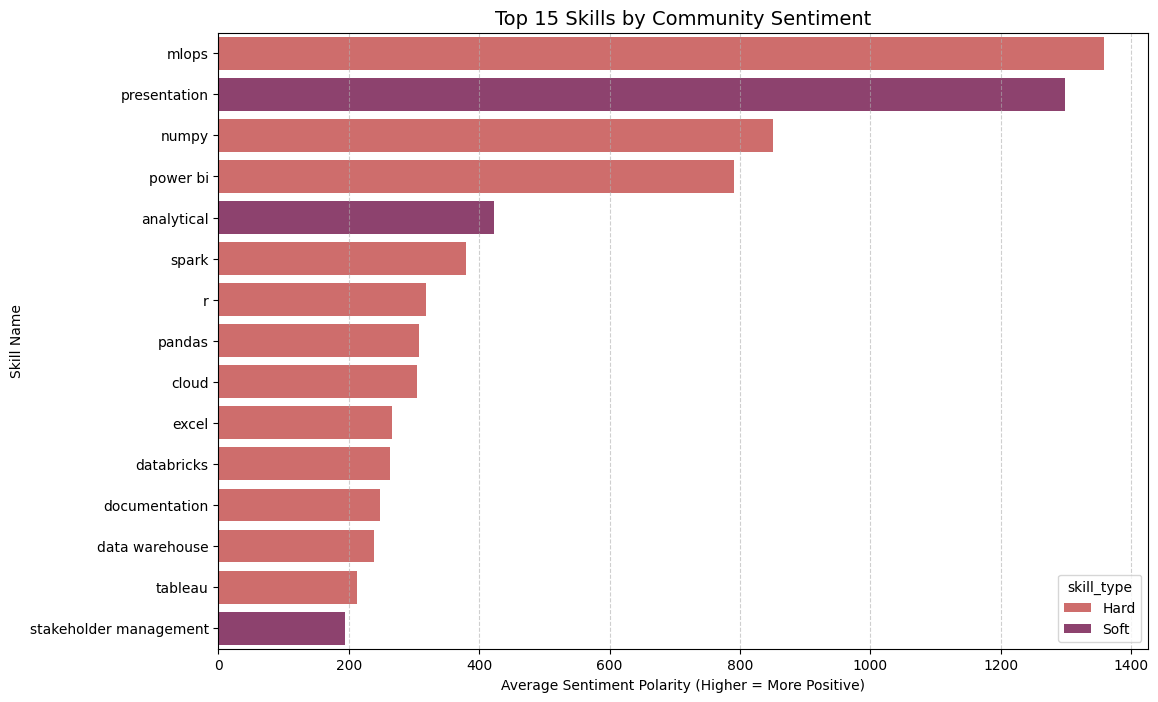

In [ ]:
# 1. Sort by Sentiment instead of Outcome
top_sentiment_skills = final_skillsanalysis_df.nlargest(15, 'positive_sentimentscore')

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_sentiment_skills,
    x='positive_sentimentscore',
    y='skill',
    hue='skill_type',
    palette='flare'
)

plt.title('Top 15 Skills by Community Sentiment', fontsize=14)
plt.xlabel('Average Sentiment Polarity (Higher = More Positive)')
plt.ylabel('Skill Name')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

## Defining Job "outcome" (Influenced by sentiment and engagement direction)

In [ ]:
def calculate_refined_outcome_score(row):
    # Anchor words for positive outcomes
    anchors = ['hired', 'offer', 'got the job', 'started', 'accepted']

    # 1. Base Score = Sentiment * Engagement
    base_score = row['sentiment_polarity'] * row['engagement_metric']

    # 2. Guardrail: Does it contain an anchor word AND is the sentiment positive?
    has_anchor = any(anchor in row['processed_text_content'].lower() for anchor in anchors)

    # Logic: If it says "hired" but sentiment is negative, it's a false positive.
    # We only double the score if sentiment is > 0.1
    if has_anchor and row['sentiment_polarity'] > 0.1:
        return base_score * 2
    else:
        return base_score

# Final Outcome Score
global_master_df['outcome_driver_score'] = global_master_df.apply(calculate_refined_outcome_score, axis=1)

In [ ]:
global_master_df.head()

,post_id,text_content,comment_score,comment_rank,type,score,num_comments_for_post,processed_text_content,category,identified_hard_skills,...,hard_skill_score,soft_skill_score,total_skill_score,post_upvotes,total_comments_on_post,engagement_metric,overall_weighted_skill_engagementscore,sentiment_polarity,positive_sentimentscore,outcome_driver_score
0,1qx1cr3,Ten years ago I had to write SAS code on a whi...,1.0,1.0,comment,0.0,NaN,ten years ago i had to write sas code on a whi...,datascience,[],...,0,0,0,4.0,1.0,5.0,0.0,0.0000,0.0000,0.0000
1,1qx11ri,In general I think causal inference / MMM is m...,1.0,1.0,comment,0.0,NaN,in general i think causal inference mmm is mo...,datascience,[],...,0,0,0,2.0,5.0,7.0,0.0,0.9494,6.6458,6.6458
2,1qx11ri,What country are you in and industry ?\n\nSoun...,1.0,2.0,comment,0.0,NaN,what country are you in and industry \n\nsound...,datascience,[],...,0,0,0,2.0,5.0,7.0,0.0,0.3612,2.5284,2.5284
3,1qx11ri,As someone that do both types of work (we use ...,1.0,3.0,comment,0.0,NaN,as someone that do both types of work we use m...,datascience,[],...,0,0,0,2.0,5.0,7.0,0.0,0.0000,0.0000,0.0000
4,1qx11ri,From a recent review of job ads compared to 3y...,1.0,4.0,comment,0.0,NaN,from a recent review of job ads compared to 3y...,datascience,[mlops],...,1,0,1,2.0,5.0,7.0,7.0,0.7603,5.3221,5.3221


In [ ]:
global_master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5839 entries, 0 to 5838
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   post_id                                 5839 non-null   object 
 1   text_content                            5839 non-null   object 
 2   comment_score                           5839 non-null   float64
 3   comment_rank                            4704 non-null   float64
 4   type                                    5839 non-null   object 
 5   score                                   5839 non-null   float64
 6   num_comments_for_post                   1135 non-null   float64
 7   processed_text_content                  5839 non-null   object 
 8   category                                5839 non-null   object 
 9   identified_hard_skills                  5839 non-null   object 
 10  identified_soft_skills                  5839 non-null   obje

# Results

In [ ]:
#1. Extract and unpivot skills
hard_skills_df = global_master_df.explode('identified_hard_skills').dropna(subset=['identified_hard_skills'])
hard_skills_df['skill_type'] = 'Hard'
hard_skills_df = hard_skills_df.rename(columns={'identified_hard_skills': 'skill'})

soft_skills_df = global_master_df.explode('identified_soft_skills').dropna(subset=['identified_soft_skills'])
soft_skills_df['skill_type'] = 'Soft'
soft_skills_df = soft_skills_df.rename(columns={'identified_soft_skills': 'skill'})

#2. Concatenate into long-format
skills_long_df = pd.concat([ hard_skills_df[['skill', 'skill_type', 'category', 'outcome_driver_score', 'positive_sentimentscore', 'overall_weighted_skill_engagementscore']], soft_skills_df[['skill', 'skill_type', 'category', 'outcome_driver_score', 'positive_sentimentscore', 'overall_weighted_skill_engagementscore']] ])

#3. Create the Subreddit FREQUENCY Matrix
#crosstab by default returns the count (frequency) of occurrences
subreddit_totals = skills_long_df.groupby('category').size()

#4. Get the Raw Frequency Matrix (from previous step)
subreddit_counts = pd.crosstab(skills_long_df['skill'], skills_long_df['category'])

#5. Aggregate metrics by skill
skills_metrics_summary = skills_long_df.groupby(['skill', 'skill_type']).agg({
    'outcome_driver_score': 'mean',
    'positive_sentimentscore': 'mean',
    'overall_weighted_skill_engagementscore': 'mean'
}).reset_index()

#6. Normalize: (Skill Mentions in Subreddit) / (Total Skill Mentions in Subreddit)
#We multiply by 100 to get a percentage (%)
normalized_matrix = subreddit_counts.div(subreddit_totals, axis=1) * 100

#7. Rename columns to indicate these are Percentages/Shares
normalized_matrix.columns = [f"{col}_share_pct" for col in normalized_matrix.columns]
normalized_matrix = normalized_matrix.reset_index()

#8. Merge with your Metrics Summary
final_skillsanalysis_df = pd.merge( skills_metrics_summary, normalized_matrix, on='skill', how='left' )

#9. Final Sort by Outcome Score
final_skillsanalysis_df = final_skillsanalysis_df.sort_values(by='outcome_driver_score', ascending=False)

print("Top Skills by Outcome Score with Subreddit Share (%)")
print(final_skillsanalysis_df.head(10))

Top Skills by Outcome Score with Subreddit Share (%)
           skill skill_type  outcome_driver_score  positive_sentimentscore  \
27         mlops       Hard           1358.747975              1358.747975   
34  presentation       Soft           1298.417500              1298.417500   
29         numpy       Hard            850.834767               850.834767   
33      power bi       Hard            795.123256               791.206722   
2     analytical       Soft            571.718650               423.024775   
39         spark       Hard            384.181943               379.828354   
8          cloud       Hard            338.513622               303.899026   
38             r       Hard            329.641861               318.723759   
30        pandas       Hard            307.819702               307.495443   
23         excel       Hard            277.684914               265.798089   

    overall_weighted_skill_engagementscore  analytics_share_pct  \
27                   

In [ ]:
final_skillsanalysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, 27 to 1
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   skill                                   47 non-null     object 
 1   skill_type                              47 non-null     object 
 2   outcome_driver_score                    47 non-null     float64
 3   positive_sentimentscore                 47 non-null     float64
 4   overall_weighted_skill_engagementscore  47 non-null     float64
 5   analytics_share_pct                     47 non-null     float64
 6   dataanalysis_share_pct                  47 non-null     float64
 7   dataanalytics_share_pct                 47 non-null     float64
 8   dataengineering_share_pct               47 non-null     float64
 9   datascience_share_pct                   47 non-null     float64
dtypes: float64(8), object(2)
memory usage: 4.0+ KB


In [ ]:
all_defined_skills = set(General_HardSkills + General_SoftSkills)
skills_in_analysis = set(final_skillsanalysis_df['skill'].unique())

missing_skills = list(all_defined_skills - skills_in_analysis)

print(f"Total unique skills defined in lexicons: {len(all_defined_skills)}")
print(f"Total unique skills found in analysis: {len(skills_in_analysis)}")
print(f"Number of missing skills: {len(missing_skills)}")
print("Missing skills:")
for skill in missing_skills:
    print(f"- {skill}")

Total unique skills defined in lexicons: 50
Total unique skills found in analysis: 47
Number of missing skills: 3
Missing skills:
- scikit-learn
- crossfunctional
- model deployment


# Analysis & Reporting

/tmp/ipython-input-2002148756.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2002148756.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Skill Type')


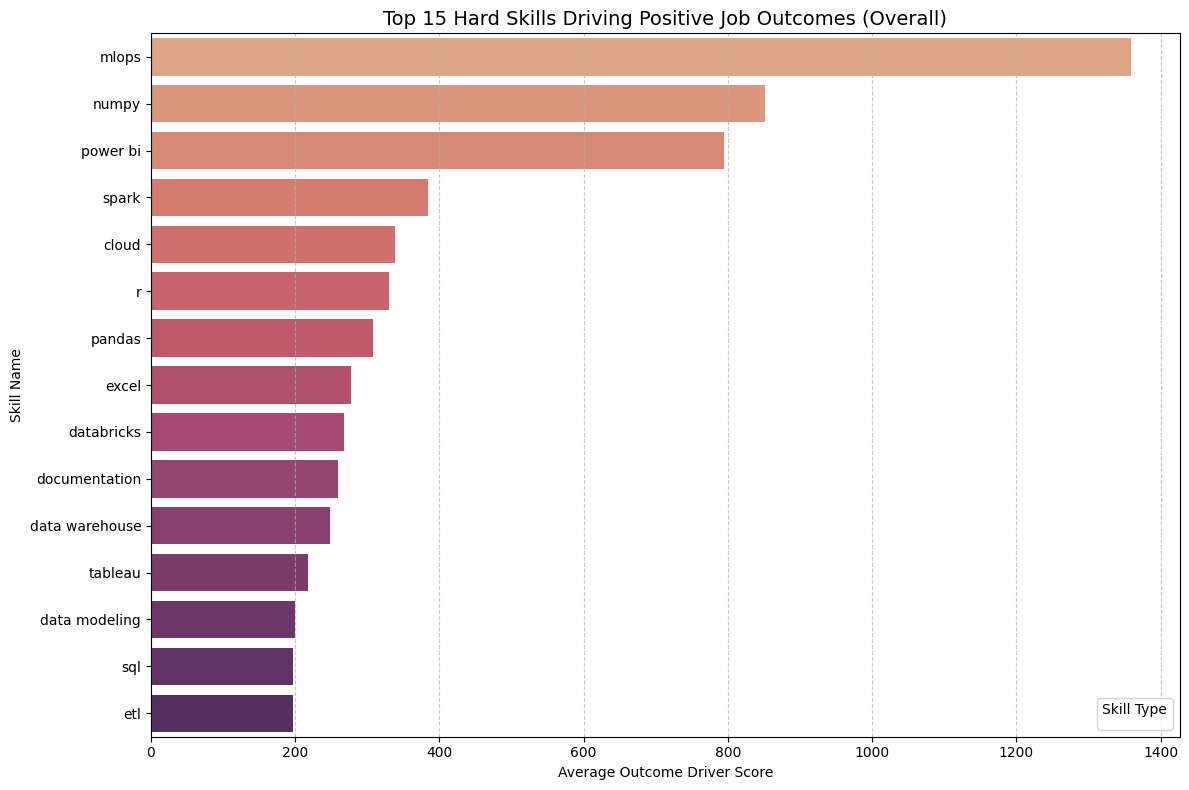

In [ ]:
# 1. Filter for the top 15 hard skills overall
hard_top_15 = final_skillsanalysis_df[final_skillsanalysis_df['skill_type'] == 'Hard'].nlargest(15, 'outcome_driver_score')

# 2. Plotting
plt.figure(figsize=(12, 8))
sns.barplot(
    data=hard_top_15,
    x='outcome_driver_score',
    y='skill',
    palette='flare'
)

plt.title('Top 15 Hard Skills Driving Positive Job Outcomes (Overall)', fontsize=14)
plt.xlabel('Average Outcome Driver Score')
plt.ylabel('Skill Name')
plt.legend(title='Skill Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipython-input-981931103.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-981931103.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Skill Type')


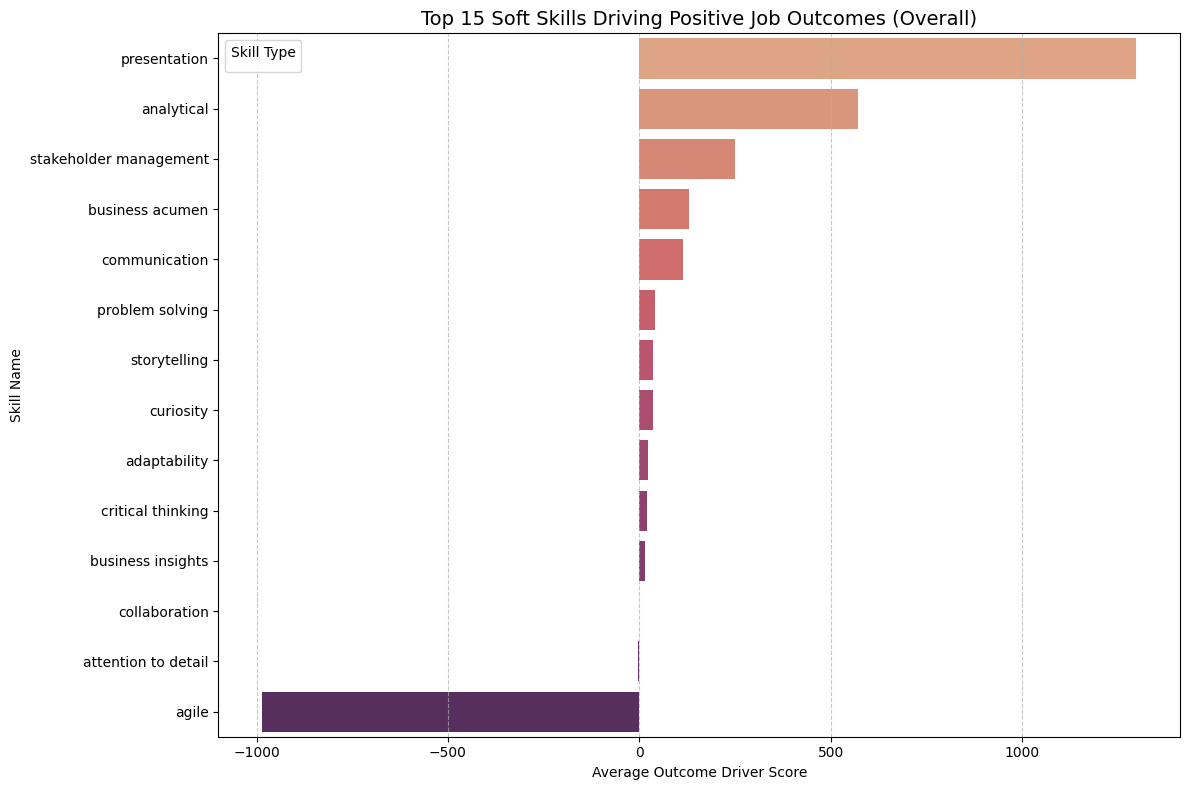

In [ ]:
# 1. Filter for the top 15 soft skills overall
soft_top_15 = final_skillsanalysis_df[final_skillsanalysis_df['skill_type'] == 'Soft'].nlargest(15, 'outcome_driver_score')

# 2. Plotting
plt.figure(figsize=(12, 8))
sns.barplot(
    data=soft_top_15,
    x='outcome_driver_score',
    y='skill',
    palette='flare'
)

plt.title('Top 15 Soft Skills Driving Positive Job Outcomes (Overall)', fontsize=14)
plt.xlabel('Average Outcome Driver Score')
plt.ylabel('Skill Name')
plt.legend(title='Skill Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Quick View into Subreddits

### Hard Skills

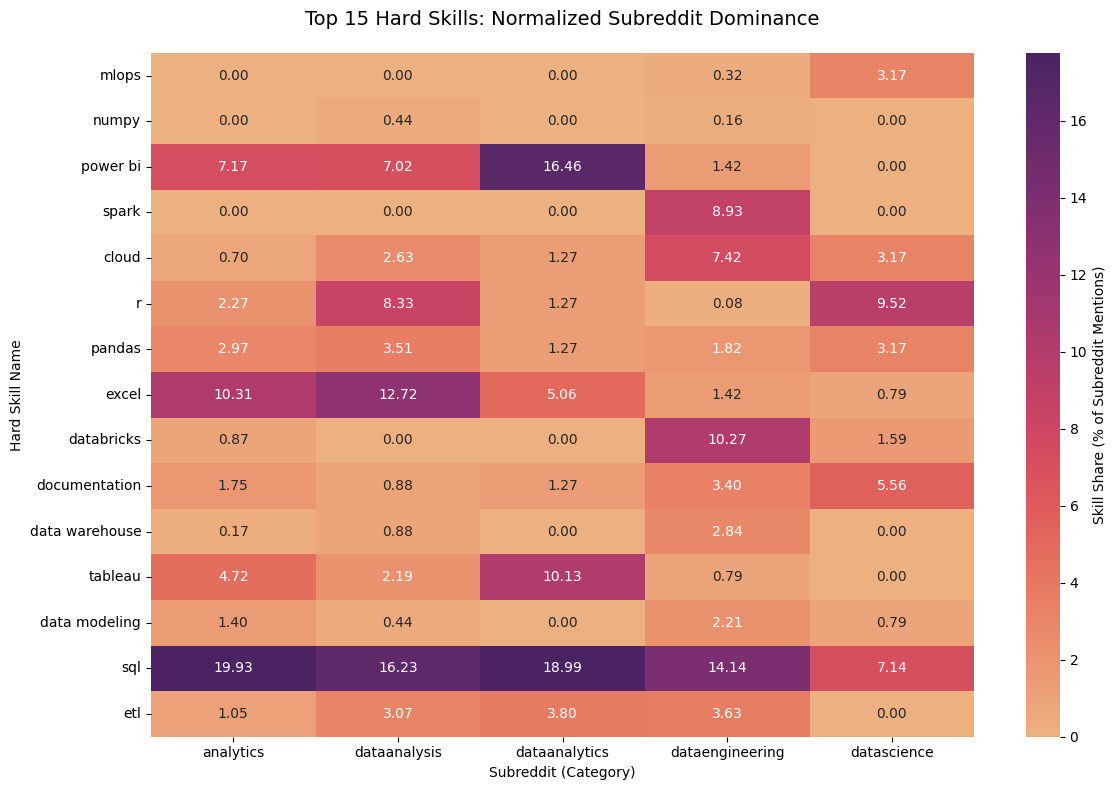

In [ ]:
# 1. Identify the share columns and subreddit labels
share_cols = [col for col in final_skillsanalysis_df.columns if '_share_pct' in col]
subreddit_names = [col.replace('_share_pct', '') for col in share_cols]

# 2. Filter for Top 15 Hard Skills by Outcome Score
hard_top_15 = final_skillsanalysis_df[final_skillsanalysis_df['skill_type'] == 'Hard'].nlargest(15, 'outcome_driver_score')

# 3. Prepare data and plot
viz_hard = hard_top_15.set_index('skill')[share_cols]
viz_hard.columns = subreddit_names

plt.figure(figsize=(12, 8))
sns.heatmap(
    viz_hard,
    annot=True,
    cmap='flare',
    robust=True,
    fmt=".2f",
    cbar_kws={'label': 'Skill Share (% of Subreddit Mentions)'}
)

plt.title('Top 15 Hard Skills: Normalized Subreddit Dominance', fontsize=14, pad=20)
plt.ylabel('Hard Skill Name')
plt.xlabel('Subreddit (Category)')
plt.tight_layout()
plt.show()

### Soft Skills

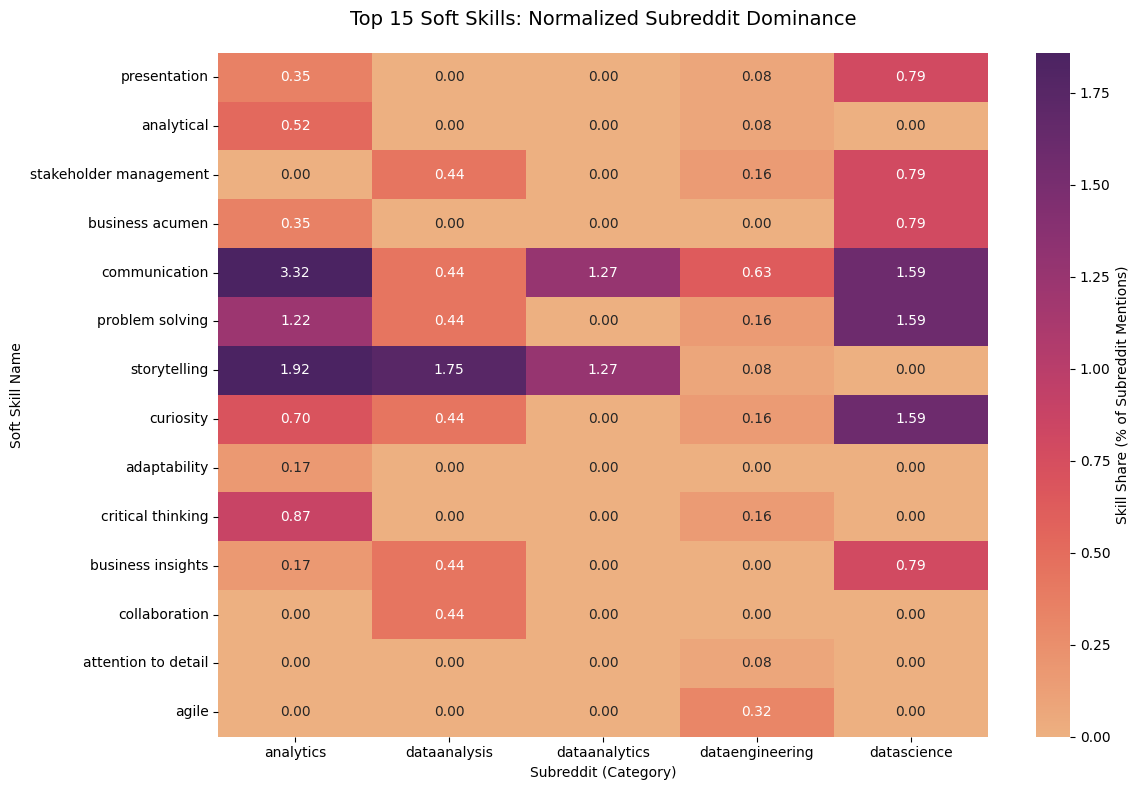

In [ ]:
# 1. Identify the share columns and subreddit labels
share_cols = [col for col in final_skillsanalysis_df.columns if '_share_pct' in col]
subreddit_names = [col.replace('_share_pct', '') for col in share_cols]

# 2. Filter for Top 15 Soft Skills by Outcome Score
soft_top_15 = final_skillsanalysis_df[final_skillsanalysis_df['skill_type'] == 'Soft'].nlargest(15, 'outcome_driver_score')

# 3. Prepare data and plot
viz_soft = soft_top_15.set_index('skill')[share_cols]
viz_soft.columns = subreddit_names

plt.figure(figsize=(12, 8))
sns.heatmap(
    viz_soft,
    annot=True,
    cmap='flare',
    robust=True,
    fmt=".2f",
    cbar_kws={'label': 'Skill Share (% of Subreddit Mentions)'}
)

plt.title('Top 15 Soft Skills: Normalized Subreddit Dominance', fontsize=14, pad=20)
plt.ylabel('Soft Skill Name')
plt.xlabel('Subreddit (Category)')
plt.tight_layout()
plt.show()

## Key Insights from Skill Analysis

1.  Skills like **MLOps**, **Power BI**, **Spark**, and **Python** are highly valued and linked to positive job outcomes.
2.  Soft skills such as **Presentation**, **Analytical Thinking**, **Stakeholder Management**, and **Communication** are strong drivers of success.
3.  While niche skills like **MLOps** offer high impact, foundational hard skills like **SQL**, **Python**, **Pandas**, and **Cloud** are pervasive across all data disciplines. Students should aim for a solid foundation in these core tools before or while specializing. Understanding which subreddits discuss which skills most frequently can guide where to invest deeper learning for a desired career path.
